In [1]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

## Estimates from Factor Model
We assume a factor model where there are $k$ assets and $T$ time periods (months in our case), m is the common factors (topic weights in our case). $r_{it}$ is the return for asset $i$ at time $t$.

$$
\begin{align}
r_{it}
= &\alpha_i + \sum_{j=1}^{m} \beta_{ij} f_jt + \epsilon_{it}, t = 1, \dots, T, i = 1, \dots, k\\ \\
R_{k \times T} = & B_{k \times m} \cdot coef_{m \times T} + E_{k \times T}
\end{align}
$$

In our analysis, $R_{k \times T}$ is the returns matrix imported, $B_{k \times m}$ is the topic modeling matrix, and $coef_{m \times T}$ is the coefficient matrix computed from the linear regression of returns matrix on topic modeling matrix. $E_{k \times T}$ is the residual matrix.

In our factor model, 

$$\Sigma_R = B \Sigma_{coef} B^T + D, 
\text{ where } D = diag(\sigma^2_1, \dots, \sigma^2_k) \text{ and Var}(\epsilon_i) = \sigma^2_i$$


With the covariance developed from the factor model, we are able to convert the covariance into correlation matrix. Then, we use this correlation matrix and sample return standard deviation to calculate the estimated covariance.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import string
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [3]:
r_selected = pd.read_csv("data/filtered_r.csv")
# get the mean of all 
r_selected.set_index("name", inplace = True)
mu = r_selected.mean(axis = 1)
# compute the covariance matrix 
cov = r_selected.T.cov()

In [4]:
df = pd.read_csv('../data/preprocessed.csv',
                 usecols = ['reportingDate', 'name', 'CIK', 'coDescription',
                           'coDescription_stopwords', 'SIC', 'SIC_desc'])
df = df.set_index(df.name)

### Sent-LDA
We ran the coherence score benchmarking over a range of 3 to 40 topics, incrementing by 3. 

First, we fit the LDA model to all business description using the number of topics selected from coherence score benchmarking. 

Then, we assume each sentence only represents one topic; get the frequency of the topics revealed in the whole document (business description for one company) and calculate the probability of each topics in the whole document. 

#### Coherence Score Plot

![Factor_Model_Coherence_Score.png](images/Factor_Model_Coherence_Score.png)

Based on the above Coherence Score, we choose up to 12 topics since it gives the highest score up to here.

In [5]:
data = df.loc[:,"coDescription_stopwords"].to_list()

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.85, min_df=2, max_features=600)
tf = tf_vectorizer.fit_transform(data)
tf_feature_names = tf_vectorizer.get_feature_names_out()
lda = LatentDirichletAllocation(n_components=12, random_state=0).fit(tf)

We show the top 10 words by weights in the 12 topics LDA model generates in the below table.

In [7]:
std_func.get_topics(lda, tf_vectorizer, 12)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12
0,could,loan,share,product,investment,gas,hotel,patient,bank,customer,million,cell
1,gas,mortgage,stock,drug,income,oil,facility,treatment,capital,service,tax,cancer
2,regulation,real,note,fda,asset,natural,tenant,trial,institution,data,asset,tumor
3,oil,estate,issued,clinical,reit,production,lease,study,federal,product,net,product
4,future,commercial,preferred,patent,real,reserve,operating,phase,act,solution,income,therapy
5,natural,bank,date,approval,tax,proved,estate,clinical,banking,software,cash,therapeutic
6,price,interest,amount,trial,share,drilling,million,disease,holding,platform,expense,clinical
7,affect,rate,september,application,interest,regulation,real,drug,regulation,technology,value,technology
8,ability,million,per,regulatory,distribution,net,center,therapy,deposit,application,note,research
9,adversely,security,director,candidate,estate,water,portfolio,data,asset,sale,statement,license


#### Frequency of the Topics in Each Sentence

In [8]:
n_components = 12
prob = pd.DataFrame(0, index = df.name, columns = range(n_components))

In [9]:
for j in range(len(df)):
    LIST_sent = pd.Series(df.coDescription[j].split('.')).apply(std_func.lemmatize_sentence).apply(std_func.remove_nums).apply(std_func.remove_stopwords)
    
    X = tf_vectorizer.transform(LIST_sent.tolist())
    sent = lda.transform(X)
    sent_df = pd.DataFrame(sent)
    # drop the values that are smaller than 1/12
    # if the maximum value is 1/12, the probability of each topic in that sentence is the same
    # we cannot determine which topic to choose
    sent_df = sent_df[sent_df.max(axis = 1) > 1/12].reset_index(drop = True)

    for i in range(n_components):
        prob.iloc[j][i] = list(sent_df.idxmax(axis = 1)).count(i)
    
    # calculate the probability
    prob = prob.div(prob.sum(axis=1), axis=0)

In [10]:
prob

,0,1,2,3,4,5,6,7,8,9,10,11
name,,,,,,,,,,,,
"MONGODB, INC.",0.014652,0.007326,0.021978,0.036630,0.018315,0.010989,0.040293,0.021978,0.014652,0.739927,0.047619,0.025641
SALESFORCE COM INC,0.010811,0.010811,0.005405,0.016216,0.000000,0.021622,0.037838,0.005405,0.005405,0.821622,0.054054,0.010811
SPLUNK INC,0.010274,0.003425,0.013699,0.020548,0.013699,0.003425,0.023973,0.000000,0.003425,0.839041,0.058219,0.010274
"OKTA, INC.",0.020305,0.000000,0.015228,0.050761,0.015228,0.005076,0.040609,0.000000,0.015228,0.786802,0.030457,0.020305
VEEVA SYSTEMS INC,0.093245,0.012845,0.094196,0.028544,0.035205,0.008563,0.019981,0.010466,0.017602,0.315414,0.352046,0.011893
...,...,...,...,...,...,...,...,...,...,...,...,...
"AMERICAN REALTY CAPITAL NEW YORK CITY REIT, INC.",0.075472,0.084906,0.122642,0.009434,0.471698,0.009434,0.075472,0.000000,0.000000,0.066038,0.084906,0.000000
"CYCLACEL PHARMACEUTICALS, INC.",0.027460,0.000000,0.029748,0.272311,0.011442,0.009153,0.018307,0.308924,0.000000,0.029748,0.013730,0.279176
ZOETIS INC.,0.036519,0.018868,0.074254,0.033475,0.034084,0.013999,0.035301,0.018868,0.020694,0.053561,0.644553,0.015825


### Factor Modelling
The common factors in our factor model are the 12 topics selected from LDA model. We use the calculated probability matrix of each topic for each companies as the topic modelling matrix $B$. Then a linear regression of returns matrix on topic modelling matrix will give us the coefficient matrix for the 12 factors. 

At each time $t$, we run a linear regression of $r_t$ on the topic modelling matrix (common factor matrix) $B$ to generate a coefficient vector for time $t$. At the same time, a residual vector $\epsilon_t$ can be calculated using the diffrence of the actual $r_t$ along with the predicted value $\hat r_t$.

After $T$ times (31 months in our case) of linear regression, we have a coefficient matrix $coef_{T\times m}$ with 12 topics as columns and 31 months as rows as well as a residual matrix with 31 months as columns and the number of companies as rows. We will construct the diagonal matrix $D$ using the diagonal values of covariance of the resiudal matrix which are the variance of residuals $\text{Var}(\epsilon_{i1}, \epsilon_{i2}, \dots, \epsilon_{iT})$ for each company.

#### Demonstration in Pharmaceutical Preparations Industry

In [11]:
# get the names of the companies in the pharmaceutical preparations industry
Pharm = df[df.SIC == 2834]
Pharm_list = Pharm.index

In [12]:
# get the companies name that match return data and business description data
SET = (set(Pharm_list) & set(r_selected.index))
LIST = [*SET, ]

In [13]:
B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

#### Topic Matrix: ${B_{k \times m}}$

In [14]:
B_matrix

,0,1,2,3,4,5,6,7,8,9,10,11
name,,,,,,,,,,,,
CATABASIS PHARMACEUTICALS INC,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.807692,0.000000,0.038462,0.000000,0.076923
PORTOLA PHARMACEUTICALS INC,0.025641,0.006410,0.038462,0.394231,0.009615,0.019231,0.025641,0.230769,0.006410,0.083333,0.048077,0.112179
ARENA PHARMACEUTICALS INC,0.164071,0.004154,0.047767,0.377985,0.021807,0.011423,0.018692,0.155763,0.013499,0.044652,0.062305,0.077882
"ACTINIUM PHARMACEUTICALS, INC.",0.003300,0.003300,0.016502,0.105611,0.000000,0.003300,0.019802,0.504950,0.003300,0.062706,0.006601,0.270627
"TELIGENT, INC.",0.023158,0.061053,0.056842,0.395789,0.021053,0.018947,0.071579,0.023158,0.018947,0.136842,0.143158,0.029474
...,...,...,...,...,...,...,...,...,...,...,...,...
"FORTRESS BIOTECH, INC.",0.023256,0.003322,0.132890,0.033223,0.029900,0.009967,0.029900,0.136213,0.019934,0.029900,0.491694,0.059801
ZOETIS INC.,0.036519,0.018868,0.074254,0.033475,0.034084,0.013999,0.035301,0.018868,0.020694,0.053561,0.644553,0.015825
XOMA CORP,0.025362,0.050725,0.163043,0.144928,0.032609,0.025362,0.018116,0.032609,0.010870,0.065217,0.163043,0.268116


In [15]:
r_Pharm = r_selected.T[LIST].T

In [16]:
coef_mat = pd.DataFrame(0, index = r_Pharm.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r_Pharm.index, columns = r_Pharm.columns)

from sklearn.linear_model import LinearRegression

for i in range(len(r_Pharm.columns)):
    LR = LinearRegression()
    date = r_Pharm.columns[i]
    r_t_i = r_Pharm[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

#### Coefficient Matrix: $coef_{T \times m}$

In [17]:
coef_mat

,0,1,2,3,4,5,6,7,8,9,10,11
2016-06-30,0.993361,-1.875375,0.195258,-0.337758,1.312631,2.051489,1.238693,-0.392438,-2.489539,-0.470602,-0.236897,0.011175
2016-07-31,-0.587373,2.486985,-0.051766,-0.119139,0.599033,-0.509589,0.034452,-0.130789,-1.116928,-0.347125,0.009258,-0.267018
2016-08-31,-0.088389,-2.184883,0.309753,0.127562,0.202514,-0.612011,-1.106752,0.233257,1.801470,0.803841,0.164920,0.348719
2016-09-30,-0.122107,1.875134,0.171593,0.108377,0.836037,-0.015983,-1.795211,-0.121855,-0.571359,-0.409085,0.001294,0.043164
2016-10-31,-0.236524,-2.536547,-0.143964,-0.035811,-0.187329,1.460662,-0.469362,-0.034221,1.959008,0.200099,0.077996,-0.054007
2016-11-30,-1.151701,1.936744,0.147886,-0.116144,0.417320,-1.095169,-1.533299,-0.054423,1.213919,-0.113511,0.200694,0.147685
2016-12-31,0.483848,-1.161150,-0.100632,-0.193967,-0.265334,0.825843,0.407563,-0.141296,1.436270,-0.580140,-0.186887,-0.524118
2017-01-31,-0.277906,1.977522,0.574171,0.256089,-1.584684,-3.236387,0.679985,0.346124,1.308807,-0.275143,0.050787,0.180636
2017-02-28,0.895630,3.177223,0.208617,-0.125386,-3.827412,-2.817838,0.297242,0.148517,2.594685,-0.329282,-0.044365,-0.177630
2017-03-31,-1.031747,1.838094,0.056902,-0.172604,-0.423448,-1.919721,-0.909357,-0.001361,3.564327,-0.665482,-0.290407,-0.045196


#### Residual Matrix

In [18]:
res_mat

,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,...,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31
name,,,,,,,,,,,,,,,,,,,,,
CATABASIS PHARMACEUTICALS INC,0.014562,0.122499,0.032562,0.262082,-0.247374,0.016337,0.227482,-0.251828,-0.888860,0.320780,...,0.397119,-0.111670,-0.145397,-0.307846,-0.192098,-0.350677,-0.149043,0.137053,0.124740,0.050218
PORTOLA PHARMACEUTICALS INC,0.149263,0.174872,-0.403747,0.081591,-0.025065,0.026806,0.463083,-0.010613,0.250792,0.270835,...,-0.002917,0.114583,-0.167593,-0.014963,0.011493,-0.492260,-0.427259,0.024990,0.222272,0.209178
ARENA PHARMACEUTICALS INC,0.068549,0.101297,-0.222899,0.074255,0.046648,0.138361,0.077197,-0.088417,-0.115412,0.143802,...,0.140185,0.050502,-0.087256,0.164143,0.064797,-0.087525,-0.165714,0.054750,0.153258,0.118729
"ACTINIUM PHARMACEUTICALS, INC.",0.261808,0.105373,-0.246395,-0.231968,-0.098437,0.029222,0.150670,-0.112915,0.213508,0.098694,...,0.059649,0.007906,-0.239604,0.769980,0.099858,-0.387898,-0.077035,0.152618,0.138753,0.025819
"TELIGENT, INC.",0.511356,0.049793,-0.116621,-0.035557,0.141567,0.068528,0.144526,-0.219405,-0.140693,0.189907,...,0.401073,-0.053962,-0.159040,0.212159,0.196270,-0.254345,-0.299041,-0.076831,-0.136283,-0.001374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"FORTRESS BIOTECH, INC.",0.164758,0.118501,-0.296512,0.049074,-0.069111,-0.132204,0.285446,-0.287353,0.208344,0.310982,...,0.242312,-0.093344,-0.300706,0.051999,-0.182649,-0.388763,-0.388053,-0.036105,0.437896,0.013898
ZOETIS INC.,0.224444,0.001572,-0.127044,-0.034749,0.055625,-0.104432,0.221198,-0.097595,-0.083571,0.172889,...,0.211903,0.038494,-0.120328,0.124320,0.083795,-0.158387,-0.156817,0.352950,0.037174,0.224244
XOMA CORP,-0.013126,0.161328,-0.282089,-0.371032,-0.139897,-0.135938,0.050171,-0.218613,0.028120,0.548573,...,-0.181691,0.208048,-0.317122,0.030469,0.241797,-0.467812,-0.195802,-0.036137,0.346904,0.123478


#### Diagonal Matrix: $D_{k \times k}$
$D = diag(\sigma^2_1, \dots, \sigma^2_k) \text{ and Var}(\epsilon_i) = \sigma^2_i$

In [19]:
res_mat.T.corr()

name,CATABASIS PHARMACEUTICALS INC,PORTOLA PHARMACEUTICALS INC,ARENA PHARMACEUTICALS INC,"ACTINIUM PHARMACEUTICALS, INC.","TELIGENT, INC.","INTRA-CELLULAR THERAPIES, INC.",BLUEPRINT MEDICINES CORP,"ARATANA THERAPEUTICS, INC.",WAVE LIFE SCIENCES LTD.,"GLOBAL BLOOD THERAPEUTICS, INC.",...,XENON PHARMACEUTICALS INC.,STRONGBRIDGE BIOPHARMA PLC,"SYNTHETIC BIOLOGICS, INC.","MERCK & CO., INC.","CARA THERAPEUTICS, INC.","FORTRESS BIOTECH, INC.",ZOETIS INC.,XOMA CORP,"PARATEK PHARMACEUTICALS, INC.",ALEXION PHARMACEUTICALS INC
name,,,,,,,,,,,,,,,,,,,,,
CATABASIS PHARMACEUTICALS INC,1.000000,0.237146,0.410883,-0.044557,0.358278,0.421631,0.540856,0.489085,0.242801,0.089145,...,0.078372,0.415776,0.469433,0.348928,0.256948,0.361620,0.397914,0.313542,0.511033,0.311900
PORTOLA PHARMACEUTICALS INC,0.237146,1.000000,0.660881,0.421427,0.488594,0.433992,0.558851,0.546153,0.353086,0.523460,...,0.231216,0.487895,0.521374,0.601872,0.534823,0.842659,0.546182,0.489459,0.677750,0.611200
ARENA PHARMACEUTICALS INC,0.410883,0.660881,1.000000,0.292060,0.501304,0.494110,0.609557,0.571756,0.456730,0.401107,...,0.448292,0.582476,0.380720,0.652797,0.453879,0.641528,0.588408,0.370919,0.602375,0.806105
"ACTINIUM PHARMACEUTICALS, INC.",-0.044557,0.421427,0.292060,1.000000,0.527817,0.321278,0.192861,0.357385,0.194138,0.354697,...,0.571948,0.334331,0.318383,0.626194,0.417825,0.488938,0.547242,0.373447,0.476235,0.561511
"TELIGENT, INC.",0.358278,0.488594,0.501304,0.527817,1.000000,0.656263,0.650579,0.525545,0.375844,0.339829,...,0.523551,0.572807,0.468180,0.729469,0.315330,0.564972,0.593559,0.137396,0.720823,0.653333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"FORTRESS BIOTECH, INC.",0.361620,0.842659,0.641528,0.488938,0.564972,0.425687,0.622580,0.546595,0.395026,0.497974,...,0.289635,0.647341,0.536139,0.649352,0.407231,1.000000,0.626904,0.488955,0.733823,0.606333
ZOETIS INC.,0.397914,0.546182,0.588408,0.547242,0.593559,0.508019,0.612684,0.667413,0.566329,0.450780,...,0.401331,0.701456,0.376772,0.816996,0.349550,0.626904,1.000000,0.351333,0.586984,0.602623
XOMA CORP,0.313542,0.489459,0.370919,0.373447,0.137396,0.337972,0.301643,0.278995,0.204671,0.207997,...,0.039750,0.259771,0.488151,0.376037,0.133445,0.488955,0.351333,1.000000,0.425865,0.387559


In [20]:
D_mat = pd.DataFrame(np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
D_mat.columns = B_matrix.index
D_mat

name,CATABASIS PHARMACEUTICALS INC,PORTOLA PHARMACEUTICALS INC,ARENA PHARMACEUTICALS INC,"ACTINIUM PHARMACEUTICALS, INC.","TELIGENT, INC.","INTRA-CELLULAR THERAPIES, INC.",BLUEPRINT MEDICINES CORP,"ARATANA THERAPEUTICS, INC.",WAVE LIFE SCIENCES LTD.,"GLOBAL BLOOD THERAPEUTICS, INC.",...,XENON PHARMACEUTICALS INC.,STRONGBRIDGE BIOPHARMA PLC,"SYNTHETIC BIOLOGICS, INC.","MERCK & CO., INC.","CARA THERAPEUTICS, INC.","FORTRESS BIOTECH, INC.",ZOETIS INC.,XOMA CORP,"PARATEK PHARMACEUTICALS, INC.",ALEXION PHARMACEUTICALS INC
name,,,,,,,,,,,,,,,,,,,,,
CATABASIS PHARMACEUTICALS INC,0.069254,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
PORTOLA PHARMACEUTICALS INC,0.000000,0.054117,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
ARENA PHARMACEUTICALS INC,0.000000,0.000000,0.023241,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
"ACTINIUM PHARMACEUTICALS, INC.",0.000000,0.000000,0.000000,0.053315,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
"TELIGENT, INC.",0.000000,0.000000,0.000000,0.000000,0.03783,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"FORTRESS BIOTECH, INC.",0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.050963,0.000000,0.000000,0.000000,0.000000
ZOETIS INC.,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.023229,0.000000,0.000000,0.000000
XOMA CORP,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.075197,0.000000,0.000000


#### Covariance from Factor Model: $\Sigma_{R\{k \times k\}}$
$$\Sigma_R = B \Sigma_{coef} B^T + D, 
\text{ where } D = diag(\sigma^2_1, \dots, \sigma^2_k)$$

In [ ]:
cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index
cov_Factor_Model

### Perform Mean-Variance Analysis
For demonstration, we only use the Pharmaceutical Preparations industry data to generate portfolio based on Mean-Variance Analysis. We estimate the covariance matrix based on the factor model constructed above.

In [21]:
!pip install PyPortfolioOpt

In [22]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting

#### Sample Mean for the Pharmaceutical Preparations Industry

In [23]:
mu_Pharm = mu[LIST]
mu_Pharm

name
CATABASIS PHARMACEUTICALS INC    -0.043794
PORTOLA PHARMACEUTICALS INC       0.002689
ARENA PHARMACEUTICALS INC         0.032450
ACTINIUM PHARMACEUTICALS, INC.   -0.028223
TELIGENT, INC.                   -0.034046
                                    ...   
FORTRESS BIOTECH, INC.           -0.019867
ZOETIS INC.                       0.020733
XOMA CORP                         0.027546
PARATEK PHARMACEUTICALS, INC.    -0.024066
ALEXION PHARMACEUTICALS INC      -0.007589
Length: 124, dtype: float64

#### Sample Covariance for the Pharmaceutical Preparations Industry

In [ ]:
tmp = cov[LIST].T
cov_Pharm = tmp[LIST]
cov_Pharm

#### Correlation Matric Converted from Covariance Matrix of Factor Model

In [25]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [27]:
cor_Factor_Model = correlation_from_covariance(cov_Factor_Model)
cor_Factor_Model

name,CATABASIS PHARMACEUTICALS INC,PORTOLA PHARMACEUTICALS INC,ARENA PHARMACEUTICALS INC,"ACTINIUM PHARMACEUTICALS, INC.","TELIGENT, INC.","INTRA-CELLULAR THERAPIES, INC.",BLUEPRINT MEDICINES CORP,"ARATANA THERAPEUTICS, INC.",WAVE LIFE SCIENCES LTD.,"GLOBAL BLOOD THERAPEUTICS, INC.",...,XENON PHARMACEUTICALS INC.,STRONGBRIDGE BIOPHARMA PLC,"SYNTHETIC BIOLOGICS, INC.","MERCK & CO., INC.","CARA THERAPEUTICS, INC.","FORTRESS BIOTECH, INC.",ZOETIS INC.,XOMA CORP,"PARATEK PHARMACEUTICALS, INC.",ALEXION PHARMACEUTICALS INC
name,,,,,,,,,,,,,,,,,,,,,
CATABASIS PHARMACEUTICALS INC,1.000000,0.298018,0.265998,0.349011,0.280371,0.312218,0.394700,0.337862,0.300848,0.337964,...,0.256850,0.296979,0.313578,0.359452,0.345928,0.269476,0.296409,0.187290,0.339050,0.330156
PORTOLA PHARMACEUTICALS INC,0.298018,1.000000,0.290287,0.318159,0.257235,0.255939,0.340764,0.326116,0.300493,0.275064,...,0.261299,0.256840,0.284239,0.353569,0.351432,0.251627,0.285883,0.175692,0.301175,0.309313
ARENA PHARMACEUTICALS INC,0.265998,0.290287,1.000000,0.284049,0.197125,0.282459,0.320211,0.311019,0.317936,0.298835,...,0.251173,0.270009,0.287736,0.386411,0.332128,0.253707,0.273428,0.147579,0.278672,0.394468
"ACTINIUM PHARMACEUTICALS, INC.",0.349011,0.318159,0.284049,1.000000,0.278228,0.303772,0.405974,0.359728,0.327009,0.325038,...,0.282697,0.291758,0.316101,0.377298,0.378864,0.276483,0.301649,0.204995,0.338745,0.332460
"TELIGENT, INC.",0.280371,0.257235,0.197125,0.278228,1.000000,0.226267,0.286462,0.262521,0.239047,0.280947,...,0.187728,0.227154,0.242922,0.273558,0.259807,0.194213,0.248195,0.181655,0.293586,0.225687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"FORTRESS BIOTECH, INC.",0.269476,0.251627,0.253707,0.276483,0.194213,0.236365,0.318556,0.300041,0.260402,0.250257,...,0.234597,0.240630,0.247700,0.305655,0.322824,1.000000,0.330523,0.169545,0.274960,0.290326
ZOETIS INC.,0.296409,0.285883,0.273428,0.301649,0.248195,0.250598,0.339630,0.328624,0.285366,0.275025,...,0.256654,0.260602,0.270874,0.333246,0.355499,0.330523,1.000000,0.198696,0.308086,0.304818
XOMA CORP,0.187290,0.175692,0.147579,0.204995,0.181655,0.149170,0.223027,0.204648,0.186396,0.177801,...,0.163513,0.154043,0.158994,0.199672,0.221501,0.169545,0.198696,1.000000,0.188808,0.162373


#### Estimated Covariance

In [28]:
sd = pd.DataFrame(np.sqrt(np.diag(np.diagonal(cov_Pharm))))
sd = sd.set_index(cov_Pharm.index)
sd.columns = cov_Pharm.index
Factor_Model_cov = pd.DataFrame((np.dot(np.dot(sd, cor_Factor_Model),sd))).set_index(cor_Factor_Model.index)
Factor_Model_cov.columns = cor_Factor_Model.index
Factor_Model_cov

name,CATABASIS PHARMACEUTICALS INC,PORTOLA PHARMACEUTICALS INC,ARENA PHARMACEUTICALS INC,"ACTINIUM PHARMACEUTICALS, INC.","TELIGENT, INC.","INTRA-CELLULAR THERAPIES, INC.",BLUEPRINT MEDICINES CORP,"ARATANA THERAPEUTICS, INC.",WAVE LIFE SCIENCES LTD.,"GLOBAL BLOOD THERAPEUTICS, INC.",...,XENON PHARMACEUTICALS INC.,STRONGBRIDGE BIOPHARMA PLC,"SYNTHETIC BIOLOGICS, INC.","MERCK & CO., INC.","CARA THERAPEUTICS, INC.","FORTRESS BIOTECH, INC.",ZOETIS INC.,XOMA CORP,"PARATEK PHARMACEUTICALS, INC.",ALEXION PHARMACEUTICALS INC
name,,,,,,,,,,,,,,,,,,,,,
CATABASIS PHARMACEUTICALS INC,0.065596,0.013204,0.008742,0.019089,0.011065,0.017463,0.015412,0.011666,0.014825,0.019842,...,0.013930,0.015970,0.017533,0.004555,0.018601,0.012862,0.003427,0.012591,0.014145,0.009534
PORTOLA PHARMACEUTICALS INC,0.013204,0.029926,0.006444,0.011753,0.006857,0.009669,0.008987,0.007606,0.010001,0.010908,...,0.009572,0.009329,0.010734,0.003027,0.012763,0.008112,0.002232,0.007978,0.008487,0.006033
ARENA PHARMACEUTICALS INC,0.008742,0.006444,0.016468,0.007784,0.003898,0.007916,0.006265,0.005381,0.007850,0.008791,...,0.006825,0.007275,0.008061,0.002454,0.008948,0.006067,0.001584,0.004971,0.005825,0.005707
"ACTINIUM PHARMACEUTICALS, INC.",0.019089,0.011753,0.007784,0.045604,0.009155,0.014167,0.013218,0.010356,0.013436,0.015912,...,0.012784,0.013081,0.014737,0.003987,0.016986,0.011003,0.002908,0.011491,0.011784,0.008005
"TELIGENT, INC.",0.011065,0.006857,0.003898,0.009155,0.023744,0.007614,0.006730,0.005454,0.007087,0.009924,...,0.006125,0.007349,0.008172,0.002086,0.008405,0.005577,0.001726,0.007347,0.007369,0.003921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"FORTRESS BIOTECH, INC.",0.012862,0.008112,0.006067,0.011003,0.005577,0.009620,0.009051,0.007538,0.009337,0.010691,...,0.009258,0.009415,0.010077,0.002819,0.012631,0.034730,0.002780,0.008294,0.008347,0.006100
ZOETIS INC.,0.003427,0.002232,0.001584,0.002908,0.001726,0.002470,0.002337,0.002000,0.002478,0.002846,...,0.002453,0.002470,0.002669,0.000744,0.003369,0.002780,0.002037,0.002354,0.002265,0.001551
XOMA CORP,0.012591,0.007978,0.004971,0.011491,0.007347,0.008551,0.008925,0.007242,0.009414,0.010699,...,0.009089,0.008490,0.009111,0.002593,0.012207,0.008294,0.002354,0.068901,0.008073,0.004806


#### Efficient Frontier - Pharmaceutical Preparations

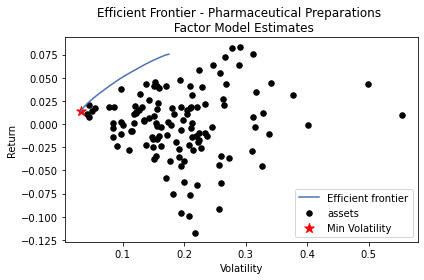

In [29]:
ef1 = EfficientFrontier(mu_Pharm, Factor_Model_cov, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, Factor_Model_cov, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - Pharmaceutical Preparations \n Factor Model Estimates")
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Returns_Pharmaceutical_Preparations.png', dpi=200, bbox_inches='tight')
plt.show()

##### Min Volatility Portfolio

###### Performance

In [30]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 1.4%
Annual volatility: 3.3%
Sharpe Ratio: -0.18


###### Weights

In [31]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Pharmaceutical_Preparations.csv", index = False)

In [32]:
pd.read_csv("data/min_vol_factor_model_Pharmaceutical_Preparations.csv")

,Company_Name,Weight
0,LILLY ELI & CO,0.1825
1,PFIZER INC,0.2000
2,JOHNSON & JOHNSON,0.2000
3,BIOSPECIFICS TECHNOLOGIES CORP,0.0175
4,"MERCK & CO., INC.",0.2000
5,ZOETIS INC.,0.2000


### Results for the Other 4 Industries

In [33]:
SIC_list = [7372, 1311, 6798, 6022]
SIC_desc = ['Prepackaged Software (mass reproduction of software)', 'Crude Petroleum and Natural Gas', 
           'Real Estate Investment Trusts', 'State Commercial Banks (commercial banking)']

#### Prepackaged Software (mass reproduction of software)

In [34]:
SIC = SIC_list[0]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r.index, columns = r.columns)

from sklearn.linear_model import LinearRegression

for i in range(len(r.columns)):
    LR = LinearRegression()
    date = r.columns[i]
    r_t_i = r[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

cor_Factor_Model = correlation_from_covariance(cov_Factor_Model)

tmp = cov[LIST].T
cov_company = tmp[LIST]

sd = pd.DataFrame(np.sqrt(np.diag(np.diagonal(cov_company))))
sd = sd.set_index(cov_company.index)
sd.columns = cov_company.index
Factor_Model_cov = pd.DataFrame((np.dot(np.dot(sd, cor_Factor_Model),sd))).set_index(cor_Factor_Model.index)
Factor_Model_cov.columns = cor_Factor_Model.index

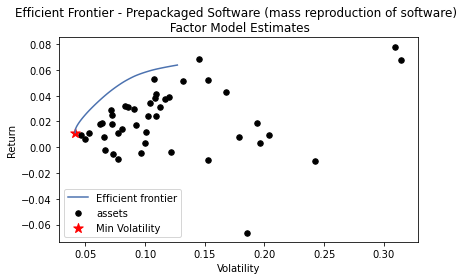

In [35]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, Factor_Model_cov, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, Factor_Model_cov, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_Prepackaged_Software.png', dpi=200, bbox_inches='tight')
plt.show()

![Efficient_Frontier_Factor_Model_Estimates_Prepackaged_Software.png](images/Efficient_Frontier_Factor_Model_Estimates_Prepackaged_Software.png)

##### Min Volatility Portfolio

###### Performance

In [36]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 1.1%
Annual volatility: 4.1%
Sharpe Ratio: -0.21


###### Weights

In [37]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Prepackaged_Software.csv", index = False)

In [38]:
pd.read_csv("data/min_vol_factor_model_Prepackaged_Software.csv")

,Company_Name,Weight
0,AWARE INC /MA/,0.06064
1,"BLACK KNIGHT, INC.",0.20000
2,REALPAGE INC,0.02255
3,ULTIMATE SOFTWARE GROUP INC,0.05857
4,"POLARITYTE, INC.",0.01095
5,SALESFORCE COM INC,0.09549
6,ANSYS INC,0.03257
7,"ACI WORLDWIDE, INC.",0.20000
8,NATIONAL INSTRUMENTS CORP,0.11657
9,ORACLE CORP,0.20000


#### Crude Petroleum and Natural Gas
When we conduct the same analysis, there is no weight shown. Efficient frontier cannot be found.

#### Real Estate Investment Trusts

In [41]:
SIC = SIC_list[2]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

mu_sample = mu[LIST]
# get the outliers
outlier = mu_sample[mu_sample>1].index
mu_sample = mu_sample.drop(outlier)
LIST = mu_sample.index

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r.index, columns = r.columns)

from sklearn.linear_model import LinearRegression

for i in range(len(r.columns)):
    LR = LinearRegression()
    date = r.columns[i]
    r_t_i = r[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

cor_Factor_Model = correlation_from_covariance(cov_Factor_Model)

tmp = cov[LIST].T
cov_company = tmp[LIST]

sd = pd.DataFrame(np.sqrt(np.diag(np.diagonal(cov_company))))
sd = sd.set_index(cov_company.index)
sd.columns = cov_company.index
Factor_Model_cov = pd.DataFrame((np.dot(np.dot(sd, cor_Factor_Model),sd))).set_index(cor_Factor_Model.index)
Factor_Model_cov.columns = cor_Factor_Model.index

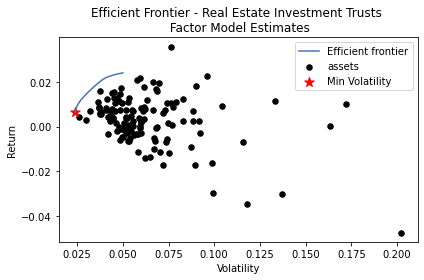

In [42]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, Factor_Model_cov, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, Factor_Model_cov, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_Real_Estate_Investment_Trusts.png', dpi=200, bbox_inches='tight')
plt.show()

![Efficient_Frontier_Factor_Model_Estimates_Real_Estate_Investment_Trusts.png](images/Efficient_Frontier_Factor_Model_Estimates_Real_Estate_Investment_Trusts.png)

##### Min Volatility Portfolio

###### Performance

In [43]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.6%
Annual volatility: 2.4%
Sharpe Ratio: -0.57


###### Weights

In [44]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Real_Estate_Investment_Trusts.csv", index = False)

In [45]:
pd.read_csv("data/min_vol_factor_model_Real_Estate_Investment_Trusts.csv")

,Company_Name,Weight
0,ALEXANDRIA REAL ESTATE EQUITIES INC,0.07207
1,GREAT AJAX CORP.,0.20000
2,SUN COMMUNITIES INC,0.05974
3,"STARWOOD PROPERTY TRUST, INC.",0.20000
4,PUBLIC STORAGE,0.01551
5,TWO HARBORS INVESTMENT CORP.,0.05921
6,"UDR, INC.",0.02051
7,ESSEX PROPERTY TRUST INC,0.03164
8,"MFA FINANCIAL, INC.",0.00089
9,EQUITY COMMONWEALTH,0.20000


#### State Commercial Banks (commercial banking)

In [46]:
SIC = SIC_list[3]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r.index, columns = r.columns)

from sklearn.linear_model import LinearRegression

for i in range(len(r.columns)):
    LR = LinearRegression()
    
    date = r.columns[i]
    r_t_i = r[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    
    reg = LR.fit(B_matrix, r_t_i_demean)
    
    coef_mat.iloc[i] = reg.coef_
    
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    
    res_mat[date] = residual_t_i

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

cor_Factor_Model = correlation_from_covariance(cov_Factor_Model)

tmp = cov[LIST].T
cov_company = tmp[LIST]

sd = pd.DataFrame(np.sqrt(np.diag(np.diagonal(cov_company))))
sd = sd.set_index(cov_company.index)
sd.columns = cov_company.index
Factor_Model_cov = pd.DataFrame((np.dot(np.dot(sd, cor_Factor_Model),sd))).set_index(cor_Factor_Model.index)
Factor_Model_cov.columns = cor_Factor_Model.index

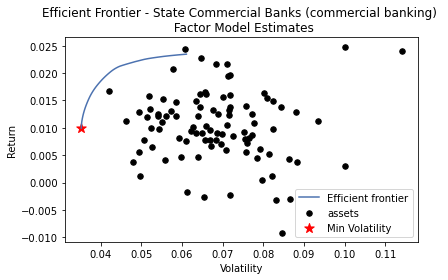

In [47]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, Factor_Model_cov, weight_bounds=(0, 0.2))


fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, Factor_Model_cov, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_State_Commercial_Banks.png', dpi=200, bbox_inches='tight')
plt.show()

![Efficient_Frontier_Factor_Model_Estimates_State_Commercial_Banks.png](images/Efficient_Frontier_Factor_Model_Estimates_State_Commercial_Banks.png)

##### Min Volatility Portfolio

###### Performance

In [48]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 1.0%
Annual volatility: 3.5%
Sharpe Ratio: -0.29


###### Weights

In [49]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_State_Commercial_Banks.csv", index = False)

In [50]:
pd.read_csv("data/min_vol_factor_model_State_Commercial_Banks.csv")

,Company_Name,Weight
0,INVESTAR HOLDING CORP,0.20000
1,CITIZENS & NORTHERN CORP,0.01769
2,GUARANTY FEDERAL BANCSHARES INC,0.05649
3,COMMERCE BANCSHARES INC /MO/,0.05022
4,BANK OF HAWAII CORP,0.07586
5,OLD LINE BANCSHARES INC,0.04698
6,"FAUQUIER BANKSHARES, INC.",0.00114
7,MACKINAC FINANCIAL CORP /MI/,0.17138
8,BANK OF THE JAMES FINANCIAL GROUP INC,0.13657
9,BANK OF NEW YORK MELLON CORP,0.04777
